# IREN - Ships Classification Project

# Legend
* [Pre-processing](#1)
    * [Loading the datas](#11)
    * [Data Augmentation](#12)
    * [Creating training & validation generators](#13)
    * [Exploratory analysis](#14)
* [Model & Training](#2)
    * [VGG-16 model](#21)
    * [Optimizer, loss, and Callbacks](#22)
    * [Training and statistics](#23)
* [Results & Interpretations](#3)
    * [Confusion Matrix](#31)
    * [Classification Report](#32)
* [Work submission](#4)

In [1]:
# === REQUIREMENT === #
!pip install albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.4.0 is successfully installed


In [2]:
# === STANDARD IMPORTS === #
import os
import random
import tarfile
import warnings
import albumentations
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
#os.environ["KERAS_BACKEND"] = "tensorflow"

# === STANDARD IMPORTS === #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# === ML LIBS IMPORTS === #
from keras.models import Sequential
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Lambda, Activation, LeakyReLU
from keras.layers import concatenate
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from keras import layers

# === GPU CONFIG === #
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-06-02 15:59:53.950716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 15:59:53.950816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 15:59:54.069668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


# Pre-processing <a class="anchor" id="1"></a>

## Loading the datas <a class="anchor" id="11"></a>

In [3]:
# === EXTRACT TRAINING / TEST DATA === #
# Path to the data
data_path = "/kaggle/input/navires-2024-fait-main/ships24.tgz"

# Extract data lock
extract = True

# Set extract to True in order to enable data extraction
if extract:
    with tarfile.open(data_path, "r:gz") as tar:
        tar.extractall()
    extract = False

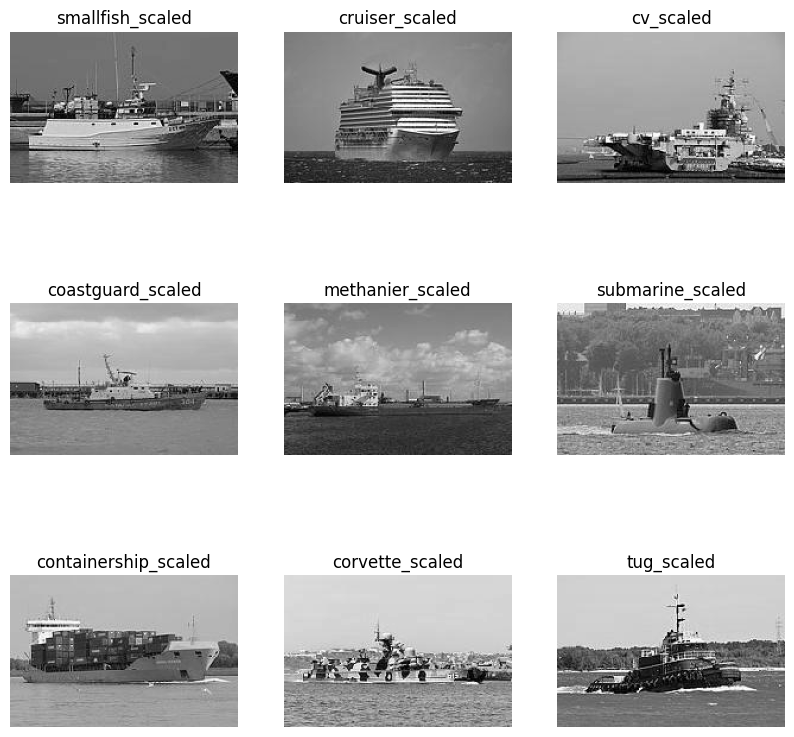

In [4]:
# === DISPLAY 9 IMAGES WITH THEIR CLASS NAMES === #
class_directory = "/kaggle/working/ships_gray"

# Get and select 9 random class directories (same process for ther basename)
all_class_dirs = [os.path.join(class_directory, d) for d in os.listdir(class_directory) if os.path.isdir(os.path.join(class_directory, d))]
random_class_dirs = random.sample(all_class_dirs, min(9, len(all_class_dirs)))
class_names = [os.path.basename(class_dir) for class_dir in random_class_dirs]


# Function to select a random image from each class directory
def select_random_image(class_dir):
    all_image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.endswith(".jpg")]
    return random.choice(all_image_paths)

random_image_paths = [select_random_image(class_dir) for class_dir in random_class_dirs]

# Function to display random images with class names
def display_random_images(image_paths, class_names):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        image = mpimg.imread(image_path)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap='gray')

        # Display class name as title
        plt.title(class_names[i])
        plt.axis("off")

    plt.show()

# Display the 9 random images with their class names
display_random_images(random_image_paths, class_names)

In [5]:
# === SET THE PARAMETERS FOR THE DATASET AND MODEL === #

seed = 12345
batch_size = 64
validation_split = 0.1  # 10% of the data is used as validation
height, width = 128, 192
color_mode = 'grayscale'
label_mode = "categorical"
extracted_dir = "/kaggle/working/ships_gray"

## Data Augmentation <a class="anchor" id="12"></a>

For the preprocessing, various data augmentation are applied to the training images to improve the generalization of the model.

We are using the method `ImageDataGenerator` from `keras` to implement the basic image transformation (rescale, translation, roation, flip, zoom, brightness, shear, channel shift and fill mode). And to take pre-processing a step further, we used `albumation` transformations to add motion blur, median blur, gaussian blur and gaussian noise.

In [6]:
# Define Albumentations augmentation pipeline
transforms_train = albumentations.Compose([
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=(3,5), always_apply=True),
        albumentations.MedianBlur(blur_limit=(3,5), always_apply=True),
        albumentations.GaussianBlur(blur_limit=(3,5), always_apply=True),
        albumentations.GaussNoise(var_limit=(1.0, 30.0), always_apply=True),
        #albumentations.Perspective(keep_size=True, interpolation=1, always_apply=True)
    ], p=0.2),
])

def custom_preprocessing_function(image):
    augmented = transforms_train(image=image)
    image = augmented["image"]
    return image

In [7]:
# Generate image using the albumentations augmentation pipeline and the keras augmentation.

imgdatagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=custom_preprocessing_function,
    rescale=1./255,
    validation_split=validation_split,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    rotation_range=15,
    zoom_range=0.15,
    fill_mode="nearest",
)

## Creating training & validation generators  <a class="anchor" id="13"></a>

In [8]:
# == LOADING TRAINING / VALIDATION GENERATORS == #

train_generator = imgdatagen.flow_from_directory(
    extracted_dir,
    target_size=(height, width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=label_mode,
    subset='training',
    seed=seed,
    shuffle=True
)

val_generator = imgdatagen.flow_from_directory(
    extracted_dir,
    target_size=(height, width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=label_mode,
    subset='validation',
    seed=seed,
)

Found 37990 images belonging to 10 classes.
Found 4214 images belonging to 10 classes.


In [9]:
# == GET INFORMATION OF CLASSES == #

class_names = list(train_generator.class_indices.keys())

# Extract the numbers of classes to predict
num_classes = len(class_names)

print(class_names)

['coastguard_scaled', 'containership_scaled', 'corvette_scaled', 'cruiser_scaled', 'cv_scaled', 'destroyer_scaled', 'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']


## Exploratory analysis  <a class="anchor" id="14"></a>

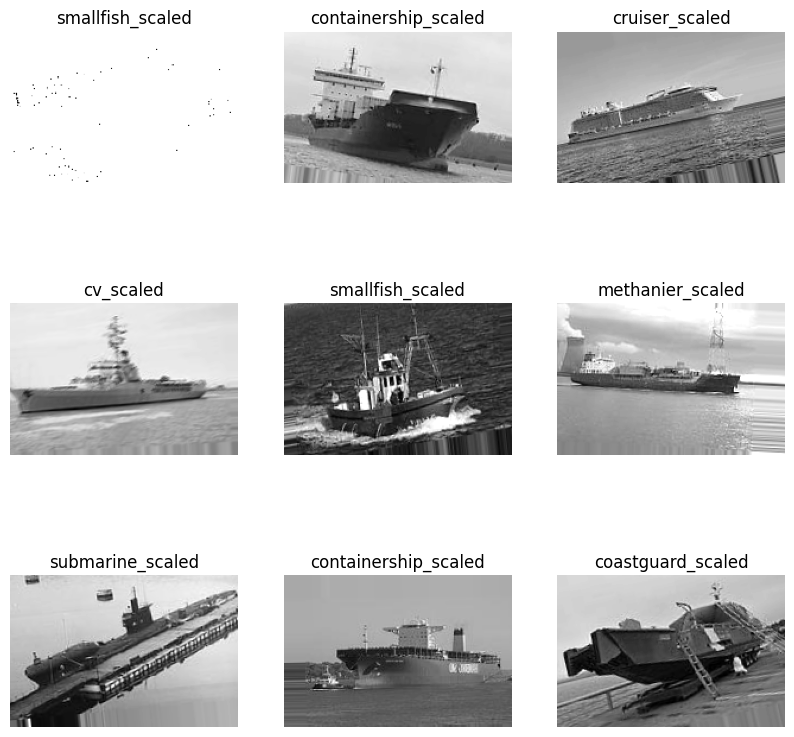

In [10]:
# == DISPLAY OF ONE TRANSFORMED BOAT FROM EACH CLASS IN THE DATASET == #

def display_random_transformed_images(generator, class_names):
    plt.figure(figsize=(10, 10))
    images, labels = next(generator)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

# Display 9 random transformed images
display_random_transformed_images(train_generator, class_names)

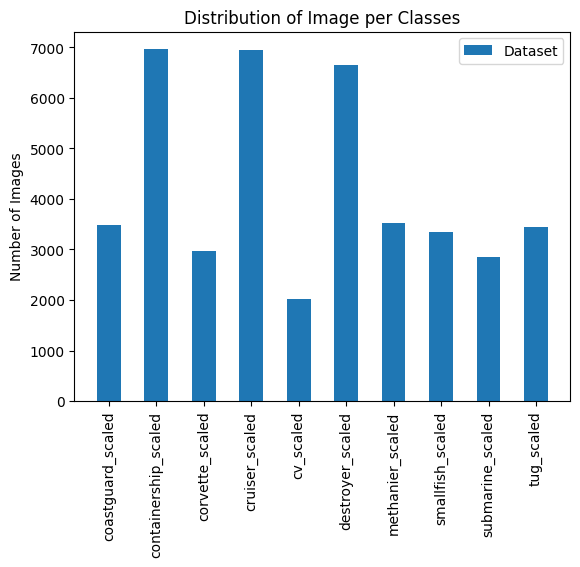

In [11]:
# === GET THE DISTRIBUTION OF SAMPLES PER CLASSES IN THE DATASET === #
counts_train = {label: sum([1 for files in os.listdir(os.path.join(extracted_dir, label))]) for label in class_names}

series_train = pd.Series(counts_train)

fig, ax = plt.subplots()
w = 0.5
x = np.arange(len(class_names))

rects1 = ax.bar(x, series_train, w, label='Dataset')

ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Image per Classes')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.show()

# Model & Training  <a class="anchor" id="2"></a>

## VGG-16 model <a class="anchor" id="21"></a>

Here, we implement a CNN architecture inspired by the VGG-16 model. It is a convolutional neural network that is 16 layers deep that has proven its efficiency in classification tasks.

In [12]:
# L2 regularization with a regularization strength of 0.001. It is applied to the fully connected layers to prevent overfitting.
reg = regularizers.L2(0.001)

def create_model():
    model = tf.keras.Sequential()
    # First Conv Block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(0.2), input_shape=(height, width, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Conv Block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(0.2)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Conv Block
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Conv Block
    model.add(layers.Conv2D(512, (3, 3), padding='same',activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), padding='same',activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Fifth Conv Block
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(0.1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation=LeakyReLU(0.1), kernel_regularizer=reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation=LeakyReLU(0.1), kernel_regularizer=reg))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Create the model
model = create_model()

# Build the model
model.build()

In [13]:
# Number of layers in the model architecutre
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  29


In [14]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 192, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 192, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 12, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 12, 512)     │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 15,656,202 (59.72 MB)

 Trainable params: 15,650,698 (59.70 MB)

 Non-trainable params: 5,504 (21.50 KB)

## Optimizer, loss, and Callbacks <a class="anchor" id="22"></a>

**Adam Optimizer:** The Adam optimizer is chosen for its efficiency and robustness. It combines the advantages of two other popular optimization techniques: AdaGrad and RMSProp. Adam is well-suited for problems that are large in terms of data (our case) and is widely used due to its adaptive learning rate properties.

**Learning Rate (0.0005)**: The learning rate of 0.0005 is chosen as a balance between convergence speed and stability. A lower learning rate might slow down the training process, while a higher learning rate could lead to instability and divergence. This value is empirically found to work well for our deep learning task.

**Categorical Crossentropy Loss:** This loss function is appropriate for multi-class classification problems where each sample can belong to one of many classes. It measures the performance of a classification model whose output is a probability value between 0 and 1.

**ReduceLROnPlateau:** monitors the val_loss to adjust the learning rate based on validation performance. This approach helps the model converge more efficiently by reducing the learning rate when it detects that the validation loss has plateaued, ensuring that the model does not overshoot the optimal weights during training.

**EarlyStopping:** monitors val_loss to stop training early if the validation performance does not improve. This prevents overfitting by stopping the training process once the model stops learning useful patterns from the data, saving computational resources and time.

**ModelCheckpoint:** monitors val_loss to save the model's weights. This callback ensures that the model's best weights are preserved, preventing the loss of progress due to overfitting or other issues during training.

In [15]:
# Optimizer of the model
optimizer = Adam(learning_rate=0.0005) #, weight_decay=5e-4)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(), # label_smoothing=0.02
              metrics=['accuracy'])

# Callback Parameters to improve training efficiency and reduce overfitting (reduce learning rate, early stopping and weights saving).
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('partial_model.h5.keras', monitor='val_loss', mode='min', save_best_only=True)
]

In [16]:
# Get the model config
model.optimizer.get_config()

{'name': 'adam',
 'learning_rate': 0.0005000000237487257,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## Training and statistics <a class="anchor" id="23"></a>

In [17]:
# === TRAIN THE MODEL === #
history = model.fit(
  train_generator,
  validation_data=val_generator,
  #class_weight=class_weights_dict,
  epochs=120,
  callbacks=callbacks
)

Epoch 1/120


2024-06-02 16:00:34.704923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.13168, expected 1.29731
2024-06-02 16:00:34.704983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.71017, expected 1.8758
2024-06-02 16:00:34.704997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.86065, expected 2.02628
2024-06-02 16:00:34.705007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.47651, expected 1.64214
2024-06-02 16:00:34.705038: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.83926, expected 2.00489
2024-06-02 16:00:34.705066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.00522, expected 2.17085
2024-06-02 16:00:34.705083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.92027, expected 2.0859
2024-06-02 16:00:34.705094: E external/local_xla/xla/serv

  1/594 ━━━━━━━━━━━━━━━━━━━━ 6:29:01 39s/step - accuracy: 0.0938 - loss: 6.6142

I0000 00:00:1717344061.203326     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717344061.234928     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


569/594 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.2569 - loss: 3.9638

2024-06-02 16:02:49.918959: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 0.994184, expected 0.360851
2024-06-02 16:02:49.919022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.97872, expected 1.34539
2024-06-02 16:02:49.919032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.70096, expected 1.06763
2024-06-02 16:02:49.919040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.27757, expected 0.644238
2024-06-02 16:02:49.919048: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.91404, expected 1.2807
2024-06-02 16:02:49.919056: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.64011, expected 1.00677
2024-06-02 16:02:49.919064: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.55943, expected 0.926094
2024-06-02 16:02:49.919072: E external/local_xla/xla

571/594 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.2572 - loss: 3.9616

W0000 00:00:1717344188.137304     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2601 - loss: 3.9367

W0000 00:00:1717344193.536522     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-02 16:03:25.561956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 0.899981, expected 0.69713
2024-06-02 16:03:25.562016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 0.938781, expected 0.73593
2024-06-02 16:03:25.562025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 0.825315, expected 0.622464
2024-06-02 16:03:25.562033: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 1.00246, expected 0.799609
2024-06-02 16:03:25.562041: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 0.943404, expected 0.740553
2024-06-02 16:03:25.562049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 0.959653, expected 0.756803
2024-06-02 16:03:25.562057: E external/local_xla/x

594/594 ━━━━━━━━━━━━━━━━━━━━ 191s 256ms/step - accuracy: 0.2602 - loss: 3.9356 - val_accuracy: 0.3958 - val_loss: 2.7495 - learning_rate: 5.0000e-04
Epoch 2/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 123s 205ms/step - accuracy: 0.4688 - loss: 2.5290 - val_accuracy: 0.5921 - val_loss: 1.9335 - learning_rate: 5.0000e-04
Epoch 3/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 123s 204ms/step - accuracy: 0.5813 - loss: 1.9288 - val_accuracy: 0.6773 - val_loss: 1.4771 - learning_rate: 5.0000e-04
Epoch 4/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.6462 - loss: 1.6025 - val_accuracy: 0.6336 - val_loss: 1.4852 - learning_rate: 5.0000e-04
Epoch 5/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 117s 194ms/step - accuracy: 0.6977 - loss: 1.3635 - val_accuracy: 0.6431 - val_loss: 1.5632 - learning_rate: 5.0000e-04
Epoch 6/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 117s 194ms/step - accuracy: 0.7351 - loss: 1.1636 - val_accuracy: 0.7779 - val_loss: 0.9831 - learning_rate: 5.0000e-04
Epoch 7/120
594/594 ━━━━━━━━━━━━━━━━━━━━ 120s 

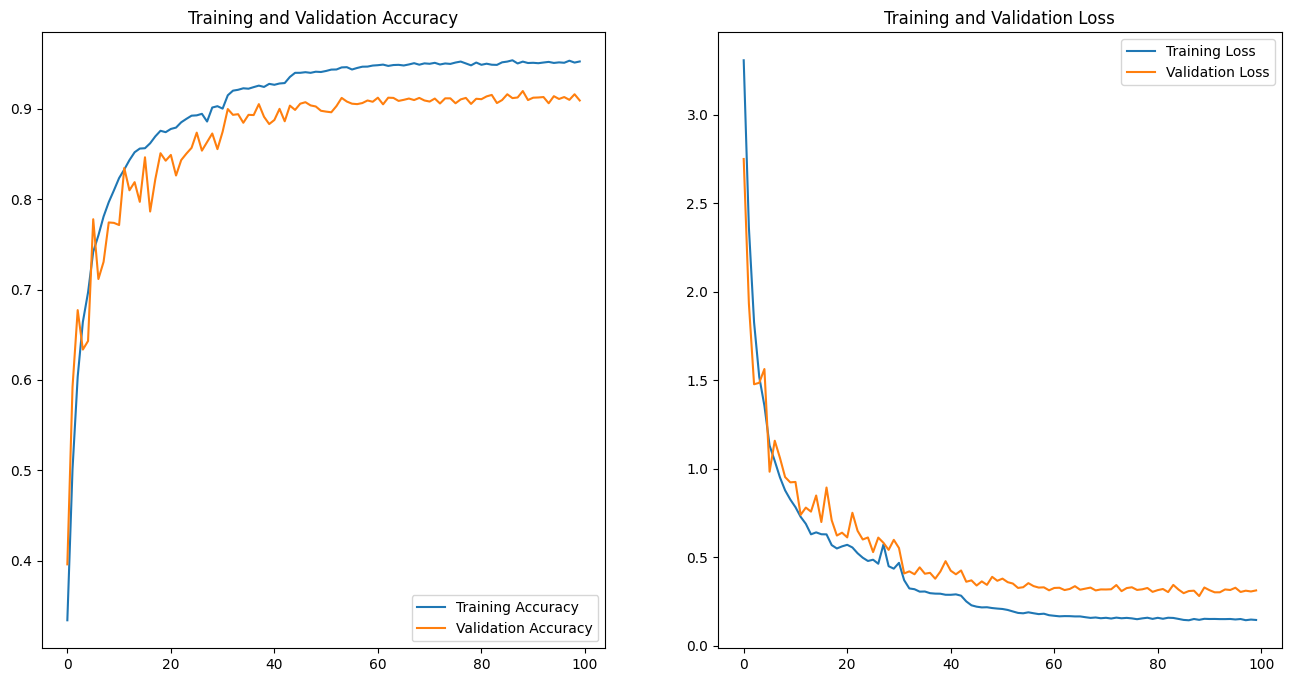

In [18]:
# === EVOLUTION OF THE ACCURACY AND VAL_ACCURACY THROUGH THE TRAINING === #

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Results & Interpretations  <a class="anchor" id="3"></a>

In [19]:
# === MATRIX CONFUSION === #

# Make predictions on validation data
matrix_data = imgdatagen.flow_from_directory(
    extracted_dir,
    target_size=(height, width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=label_mode,
    subset='validation',
    shuffle=False,
    seed=seed,
)

y_true = matrix_data.classes
y_predict = model.predict(matrix_data)

Found 4214 images belonging to 10 classes.
 3/66 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step

W0000 00:00:1717355810.550699     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step


W0000 00:00:1717355821.824736     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Confusion Matrix  <a class="anchor" id="31"></a>

Confusion Matrix


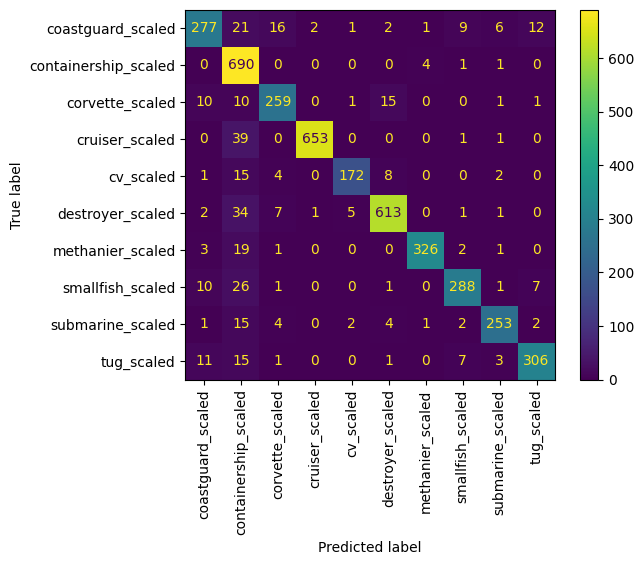

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
y_pred_classes = np.argmax(y_predict, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print('Confusion Matrix')
display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
display_matrix.plot(cmap=plt.cm.viridis)
plt.xticks(rotation=90)
plt.show()

## Classification report  <a class="anchor" id="32"></a>

In [21]:
from sklearn.metrics import classification_report

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report
                      precision    recall  f1-score   support

   coastguard_scaled       0.88      0.80      0.84       347
containership_scaled       0.78      0.99      0.87       696
     corvette_scaled       0.88      0.87      0.88       297
      cruiser_scaled       1.00      0.94      0.97       694
           cv_scaled       0.95      0.85      0.90       202
    destroyer_scaled       0.95      0.92      0.94       664
    methanier_scaled       0.98      0.93      0.95       352
    smallfish_scaled       0.93      0.86      0.89       334
    submarine_scaled       0.94      0.89      0.91       284
          tug_scaled       0.93      0.89      0.91       344

            accuracy                           0.91      4214
           macro avg       0.92      0.89      0.91      4214
        weighted avg       0.92      0.91      0.91      4214



Despite a high validation accuracy, the confusion matrix and classification report reveal areas where the model struggles, such as with the classification of the container ship. These insights are crucial for further refining the model, possibly by augmenting the data, adjusting the model architecture, or tuning hyperparameters to improve its discriminative power for challenging classes. After successive tests and the time we had left, we produced this model, which is not the best but already does very well!

# Work submission  <a class="anchor" id="4"></a>

In [22]:
# === PRODUCE OUTPUTS === #

X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255
print(X_test.shape)

(1017, 128, 192)


In [23]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

2024-06-02 19:17:03.868357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.30534, expected 1.33474
2024-06-02 19:17:03.868410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.5238, expected 1.5532
2024-06-02 19:17:03.868419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.74464, expected 1.77404
2024-06-02 19:17:03.868427: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.90685, expected 1.93625
2024-06-02 19:17:03.868435: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.25878, expected 1.28819
2024-06-02 19:17:03.868443: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.94579, expected 1.9752
2024-06-02 19:17:03.868450: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.12761, expected 2.15701
2024-06-02 19:17:03.868458: E external/local_xla/xla/servi

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

2024-06-02 19:17:09.954193: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.65884, expected 0.662364
2024-06-02 19:17:09.954263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.17118, expected 1.17471
2024-06-02 19:17:09.954273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.01663, expected 1.02015
2024-06-02 19:17:09.954280: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.22297, expected 1.22649
2024-06-02 19:17:09.954288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.01716, expected 1.02069
2024-06-02 19:17:09.954296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.82691, expected 0.830437
2024-06-02 19:17:09.954303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.60073, expected 1.60426
2024-06-02 19:17:09.954311: E external/local_xla/xla/

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step


In [24]:
!head reco_nav.csv

ID,Category
0,5
1,2
2,2
3,3
4,9
5,8
6,4
7,2
8,7


In [25]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [26]:
print('Done')

Done
